<a href="https://colab.research.google.com/github/21092004Goda/data_anal/blob/main/Lab_1_Computer_Vision_and_Pattern_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 1
**Сбор, визуализация и анализ данных по графу (cs.CV, arXiv)**

Кратко:
- Скачиваем метаданные arXiv.
- Извлекаем ключевые слова моделью Transformers.
- Строим граф ключевых слов и граф публикаций.
- Анализируем сообщества и центральные узлы.

*Внимание:* извлечение ключевых слов может быть долгим. Рекомендуется GPU и кеширование промежуточных результатов.


In [1]:
%%capture
!pip install feedparser

In [2]:
import feedparser
import urllib.request as libreq
import pandas as pd

## Сбор данных с arXiv

In [3]:
# data collection

with libreq.urlopen('http://export.arxiv.org/api/query?search_query=all:cs.CV&start=0&max_results=500') as url:
  r = url.read()
print(r)

b'<?xml version="1.0" encoding="UTF-8"?>\n<feed xmlns="http://www.w3.org/2005/Atom">\n  <link href="http://arxiv.org/api/query?search_query%3Dall%3Acs.CV%26id_list%3D%26start%3D0%26max_results%3D500" rel="self" type="application/atom+xml"/>\n  <title type="html">ArXiv Query: search_query=all:cs.CV&amp;id_list=&amp;start=0&amp;max_results=500</title>\n  <id>http://arxiv.org/api/z4PXAfIIeZ2GtEBWISFkuSpCy9o</id>\n  <updated>2025-09-22T00:00:00-04:00</updated>\n  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">167528</opensearch:totalResults>\n  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>\n  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">500</opensearch:itemsPerPage>\n  <entry>\n    <id>http://arxiv.org/abs/0903.0134v2</id>\n    <updated>2010-01-08T10:32:52Z</updated>\n    <published>2009-03-01T11:10:27Z</published>\n    <title>Recognition of Regular Shapes in Sat

## Проверка уникальности заголовков

In [4]:
# unique titles

docs = feedparser.parse(r)
titles = [d["title"] for d in docs["entries"]]
len(set(titles))

500

## Извлечение ключевых слов (Transformers)

Модель: `ilsilfverskiold/tech-keywords-extractor`.
Это тяжёлая операция. Рекомендации:
- Сначала протестируй на 5–10 абстрактах.
- Запускай на GPU.
- Кешируй результаты в CSV, чтобы не вызывать модель повторно.


In [5]:
%%time
# keywords extraction

from transformers import pipeline

pipe = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Device set to use cuda:0


CPU times: user 25.1 s, sys: 8.64 s, total: 33.7 s
Wall time: 1min 12s


In [6]:
%time
# data extraction example

doc = feedparser.parse(r)
title = doc['entries'][0]['title']
abstract = doc['entries'][0]['summary']
authors = [author['name'] for author in doc['entries'][0]['authors']]
tags = [tag['term'] for tag in doc['entries'][0]['tags']]

keywords = pipe(abstract)[0]["generated_text"].split(", ")


print(f"Title: {title}\n\nAuthors: {authors}\n\nAbstract: {abstract}\n\nTags: {tags}\n\nKeywords: {keywords}")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
Title: Recognition of Regular Shapes in Satelite Images

Authors: ['Ahmad Reza Eskandari', 'Ali Pourmohammad']

Abstract: This paper has been withdrawn by the author ali pourmohammad.

Tags: ['cs.CV']

Keywords: ['Paper', 'Ali Pourmohammad']


In [7]:
%time

pubs = []
for entry in docs["entries"]:
  data = {"title": entry['title'],
          "abstract": entry['summary'],
          "authors": [author['name'] for author in entry['authors']],
          "tags": [tag['term'] for tag in entry['tags']]}
  pubs.append(data)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


## Формирование DataFrame

In [8]:
df = pd.DataFrame(pubs)
df

,title,abstract,authors,tags
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"[Ahmad Reza Eskandari, Ali Pourmohammad]",[cs.CV]
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"[Arthur Szlam, Koray Kavukcuoglu, Yann LeCun]",[cs.CV]
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,[Anish Acharya],[cs.CV]
3,Exploration of object recognition from 3D poin...,We present our latest experiment results of ob...,[Lin Duan],[cs.CV]
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"[Sifeng He, Bahram Jalali]",[cs.CV]
...,...,...,...,...
495,An Affinity Propagation Based method for Vecto...,"In this paper, we firstly modify a parameter i...","[Wu Jiang, Fei Ding, Qiao-liang Xiang]",[cs.CV]
496,A Fast Hierarchical Multilevel Image Segmentat...,This paper proposes a novel method for segment...,"[Sreechakra Goparaju, Jayadev Acharya, Ajoy K....",[cs.CV]
497,Some Aspects of Testing Process for Transport ...,This paper presents some aspects related to th...,"[Radu Arsinte, Ciprian Ilioaei]","[cs.CV, cs.MM]"
498,Spatio-activity based object detection,We present the SAMMI lightweight object detect...,"[Jarrad Springett, Jeroen Vendrig]",[cs.CV]


## Генерация ключевых слов для всех абстрактов

In [9]:
%%time
df["keywords"] = df["abstract"].apply(lambda x: pipe(x)[0]["generated_text"].split(", "))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


CPU times: user 2min 18s, sys: 53 ms, total: 2min 19s
Wall time: 2min 27s


In [10]:
df["authors"] = df["authors"].apply(lambda x: ", ".join(x))
df["tags"] = df["tags"].apply(lambda x: ", ".join(x))
df["keywords"] = df["keywords"].apply(lambda x: ", ".join(x))

df

,title,abstract,authors,tags,keywords
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"Ahmad Reza Eskandari, Ali Pourmohammad",cs.CV,"Paper, Ali Pourmohammad"
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"Arthur Szlam, Koray Kavukcuoglu, Yann LeCun",cs.CV,"Matching Pursuit, K-SVD, Translation invariant"
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,Anish Acharya,cs.CV,"ObjectDetection, HOG, Feature Pyramid, Templat..."
3,Exploration of object recognition from 3D poin...,We present our latest experiment results of ob...,Lin Duan,cs.CV,"Object Recognition, 3D Point Cloud, Moving Car"
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"Sifeng He, Bahram Jalali",cs.CV,"Brain MRI, Algorithm, Resolution Enhancement"
...,...,...,...,...,...
495,An Affinity Propagation Based method for Vecto...,"In this paper, we firstly modify a parameter i...","Wu Jiang, Fei Ding, Qiao-liang Xiang",cs.CV,"AIAP, IAP-LBG, Vector Quantization, VQ"
496,A Fast Hierarchical Multilevel Image Segmentat...,This paper proposes a novel method for segment...,"Sreechakra Goparaju, Jayadev Acharya, Ajoy K. ...",cs.CV,"Hierarchical Multilevel Thresholding, Image Se..."
497,Some Aspects of Testing Process for Transport ...,This paper presents some aspects related to th...,"Radu Arsinte, Ciprian Ilioaei","cs.CV, cs.MM","DVB-T, Terrestrial Digital Video Broadcasting,..."
498,Spatio-activity based object detection,We present the SAMMI lightweight object detect...,"Jarrad Springett, Jeroen Vendrig",cs.CV,"SAMMI, Object Detection, DCT, Mixture of Gauss..."


In [11]:
print("Кол-во публикаций:", len(df))
print("Средняя длина аннотации:", df["abstract"].apply(lambda x: len(x.split())).mean())
all_keywords = [kw for kws in df["keywords"].str.split(",") for kw in kws]
print("Уникальных ключевых слов:", len(set(all_keywords)))
pd.Series(all_keywords).value_counts().head(20)


Кол-во публикаций: 500
Средняя длина аннотации: 50.628
Уникальных ключевых слов: 1580


,count
Computer Vision,19
Algorithms,14
CNN,14
Deep Learning,11
Image Processing,9
Machine Learning,7
Deep Learning,7
MNIST,6
Melanoma Detection,6
Object Detection,6


## Сохранение результата

In [12]:
df.drop_duplicates(subset="title", inplace=True)
print("Уникальных публикаций:", len(df))

df.to_csv("multimedia_250.csv", index=False)

Уникальных публикаций: 500


## Построение графа ключевых слов

Граф: узлы = ключевые слова, ребро между двумя словами если они встречаются в одной статье.
Вес ребра = количество совместных появлений.

Далее строим взвешенный граф и выполняем кластеризацию.


In [13]:
import pandas as pd
import networkx as nx
from itertools import combinations, chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import itemgetter
import plotly.graph_objects as go

In [14]:
df = pd.read_csv("multimedia_250.csv")
df.sample(5)

,title,abstract,authors,tags,keywords
260,Title Redacted,arXiv admin note: This version removed by arXi...,"Shivang Bharadwaj, Bhupendra Niranjan, Anant K...",cs.CV,"arXiv, Administrators, License"
164,Massively Deep Artificial Neural Networks for ...,Greedy Restrictive Boltzmann Machines yield an...,Keiron O'Shea,"cs.CV, cs.LG, cs.NE","Greedy Restrictive Boltzmann Machines, MNIST, GPU"
317,Pose Estimation Based on 3D Models,"In this paper, we proposed a pose estimation s...","Chuiwen Ma, Hao Su, Liang Shi","cs.CV, cs.LG, cs.RO","Pose Estimation System, Image Training Set, Pa..."
15,Kunchenko's Polynomials for Template Matching,This paper reviews Kunchenko's polynomials usi...,"Oleg Chertov, Taras Slipets","cs.CV, I.5.4","Kunchenko's Polynomials, Template Matching, Cr..."
297,Motion-Based Handwriting Recognition and Word ...,"In this project, we leverage a trained single-...","Junshen Kevin Chen, Wanze Xie, Yutong He",cs.CV,"Single-letter classifier, Dynamic Programming,..."


In [15]:
klist = [[word.strip() for word in keywords.split(",") if word]
         for keywords in df["keywords"].tolist()]
klist[:3]

[['Paper', 'Ali Pourmohammad'],
 ['Matching Pursuit', 'K-SVD', 'Translation invariant'],
 ['ObjectDetection', 'HOG', 'Feature Pyramid', 'Template Matching']]

In [16]:
edges = list(chain(*[list(combinations(words, 2)) for words in klist]))
edges = [tuple(sorted(edge)) for edge in edges]
weighted_edges = [(edge[0], edge[1], {"weight": edges.count(edge)}) for edge in set(edges)]
weighted_edges[:10]

[('Affine Transformation', 'Logarithmic Model', {'weight': 1}),
 ('MTL', 'Multi-Task-Learning', {'weight': 1}),
 ('Dempster-Shafer', 'Stochastic Relaxation', {'weight': 1}),
 ('Covariance Matrices', 'SVM', {'weight': 1}),
 ('CNN', 'LSTM', {'weight': 2}),
 ('Contextual Clues', 'Object Recognition', {'weight': 1}),
 ('Computer Vision', 'U-net', {'weight': 1}),
 ('Convolutional NeuralNetwork', 'Skin Lesion Analysis', {'weight': 1}),
 ('Object Detection', 'Open Images Challenge', {'weight': 1}),
 ('Long Short-Term Memory', 'Object Detection', {'weight': 1})]

In [17]:
len(set(edges)), len(weighted_edges)

(2748, 2748)

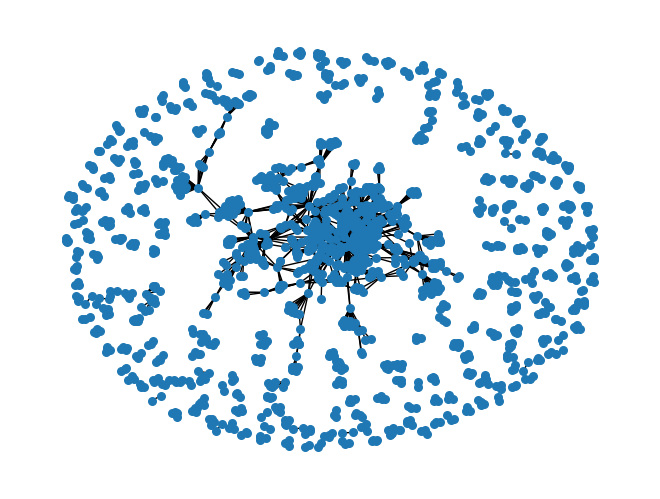

In [18]:
G = nx.Graph()
G.add_edges_from(weighted_edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

## Кластеризация (Louvain) и визуализация

- Находим сообщества Louvain.
- Выводим число кластеров и модульность.
- Визуализируем топ-3 сообщества статично (matplotlib) и интерактивно (Plotly).


In [19]:
communities = nx.community.louvain_communities(G, resolution=0.9)
print(f"# of clusters: {len(communities)}, Modularity: {nx.community.modularity(G, communities)}")

# of clusters: 248, Modularity: 0.9265888253241004


In [20]:
comm_data = [{"n_of_nodes": len(comm), "nodes": comm} for comm in communities]
cdf = pd.DataFrame(comm_data)
cdf.describe()

,n_of_nodes
count,248.000000
mean,6.173387
std,11.663908
min,2.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,118.000000


In [21]:
top3_comm = cdf.nlargest(3, "n_of_nodes")
top3_comm

,n_of_nodes,nodes
87,118,"{Artificial Neural Networks, Algonauts, CNN+Tr..."
103,64,"{Single-view Metrology, CycleGAN, Omnidirectio..."
202,61,"{Image Augmentation, Ensemble Methods, Gelomet..."


In [22]:
nodes = list(chain(*top3_comm["nodes"].tolist()))
S = G.subgraph(nodes)

In [23]:
for i, nodes in enumerate(top3_comm["nodes"], start=1):
    sub_keywords = [kw for kw in nodes]
    print(f"\nКластер {i}, размер: {len(nodes)}")
    print(pd.Series(sub_keywords).value_counts().head(10))



Кластер 1, размер: 118
Artificial Neural Networks    1
Algonauts                     1
CNN+Transformer               1
Cyclic Convolutional Layer    1
EscherNet 101                 1
U-Net                         1
Biomedical Images             1
X-ray computed tomography     1
Pytorch                       1
Diagnosis                     1
Name: count, dtype: int64

Кластер 2, размер: 64
Single-view Metrology         1
CycleGAN                      1
Omnidirectional Video         1
Hand Pose Recognition         1
Satellite Image               1
Macaque IT                    1
Line Detection                1
Hyperspectral Imagery         1
Image-to-Image Translation    1
Image-level Classification    1
Name: count, dtype: int64

Кластер 3, размер: 61
Image Augmentation            1
Ensemble Methods              1
Gelometric Model              1
Feature Transformations       1
Metropolis-Hastings Method    1
FDDB                          1
Accuracy                      1
Circle Fitting

In [24]:
def create_community_node_colors(graph, communities):
    colors = list(set(mcolors.TABLEAU_COLORS.values()))
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

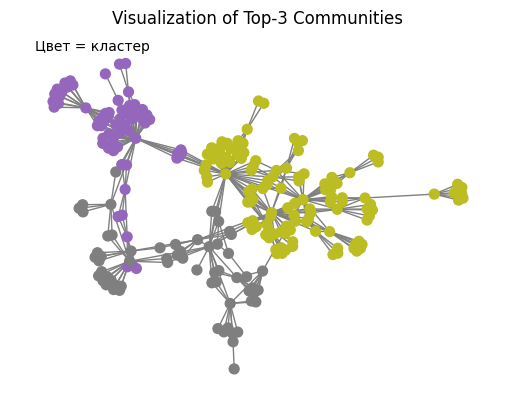

In [25]:
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    title = f"Visualization of Top-3 Communities"
    pos = nx.spring_layout(graph, iterations=100, seed=23)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=50,
        node_color=node_colors,
        edge_color="gray",
        with_labels=False
    )
    plt.text(0.05, 0.95, "Цвет = кластер", transform=plt.gca().transAxes)


visualize_communities(S, top3_comm["nodes"].tolist(), 1)

In [26]:
communities = top3_comm["nodes"].tolist()
pos = nx.spring_layout(S, iterations=100, seed=23)

# edges coordinates
x_nodes, y_nodes = zip(*pos.values())
edge_x, edge_y = [], []
for edge in S.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# degree labels
node_labels = [f"Node {n}<br>Degree: {S.degree(n)}" for n in S.nodes()]
node_degrees = [S.degree(n) for n in S.nodes()]
node_colors_list = create_community_node_colors(S, communities)

fig = go.Figure()
# add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="gray"),
))

# add nodes
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes, mode="markers",
    marker=dict(size=[deg*1.1+5 for deg in node_degrees], color=node_colors_list),
    hoverinfo="text",
    text=node_labels
))

# background settings
fig.update_layout(
    title=f"Interactive Visualization of Top-3 Communities",
    showlegend=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

fig.show()

## Оценка центральностей

Вычисляем: degree, betweenness, closeness, eigenvector.
Выводим топ-5 узлов по каждой метрике. Интерпретация:
- degree → локальная важность,
- betweenness → «мосты» между кластерами,
- eigenvector → влияние через влиятельных соседей.


In [27]:
# top-10 nodes by degree centrality
[(node[0], round(node[1],2))
for node in sorted(nx.degree_centrality(S).items(), key=itemgetter(1), reverse=True)][:10]

[('Deep Learning', 0.2),
 ('Computer Vision', 0.19),
 ('CNN', 0.14),
 ('Convolutional Neural Network', 0.12),
 ('Semantic Segmentation', 0.08),
 ('Image Segmentation', 0.07),
 ('Algorithm', 0.07),
 ('Pattern Recognition', 0.05),
 ('U-Net', 0.05),
 ('Handwriting Recognition', 0.05)]

In [28]:
# top nodes by degree centrality in top-3 communities

for i, nodes in enumerate(top3_comm["nodes"].tolist(), start=1):
  s = G.subgraph(nodes)
  top_node = max(nx.degree_centrality(s).items(), key=itemgetter(1))

  top3_nodes = [(node[0], round(node[1],2))
  for node in sorted(nx.degree_centrality(s).items(), key=itemgetter(1), reverse=True)][:3]

  print(f"# of cluster: {i}, Central node by degree: {(top_node[0], round(top_node[1], 2))}")
  print(f"Top-3 nodes: {top3_nodes}\n")


# of cluster: 1, Central node by degree: ('Deep Learning', 0.33)
Top-3 nodes: [('Deep Learning', 0.33), ('CNN', 0.26), ('Convolutional Neural Network', 0.25)]

# of cluster: 2, Central node by degree: ('Computer Vision', 0.68)
Top-3 nodes: [('Computer Vision', 0.68), ('Semantic Segmentation', 0.32), ('CycleGAN', 0.1)]

# of cluster: 3, Central node by degree: ('Image Segmentation', 0.27)
Top-3 nodes: [('Image Segmentation', 0.27), ('Algorithm', 0.27), ('Pattern Recognition', 0.2)]



In [29]:
metrics = {
    "degree": nx.degree_centrality(S),
    "betweenness": nx.betweenness_centrality(S),
    "closeness": nx.closeness_centrality(S),
    "eigenvector": nx.eigenvector_centrality(S)
}

for name, values in metrics.items():
    top5 = sorted(values.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop-5 {name} centrality:")
    for node, val in top5:
        print(f"{node}: {val:.3f}")



Top-5 degree centrality:
Deep Learning: 0.202
Computer Vision: 0.190
CNN: 0.145
Convolutional Neural Network: 0.124
Semantic Segmentation: 0.083

Top-5 betweenness centrality:
Deep Learning: 0.566
Computer Vision: 0.438
CNN: 0.288
Convolutional Neural Network: 0.261
Image Segmentation: 0.220

Top-5 closeness centrality:
Deep Learning: 0.449
CNN: 0.409
Convolutional Neural Network: 0.391
Image Segmentation: 0.385
Computer Vision: 0.382

Top-5 eigenvector centrality:
Deep Learning: 0.464
CNN: 0.350
Convolutional Neural Network: 0.259
Computer Vision: 0.253
Image Segmentation: 0.156


## Граф публикаций и поиск похожих статей

Узлы = статьи. Ребро между статьями если у них есть общие ключевые слова.
Вес = число общих ключевых слов.

Реализована функция `find_similar_papers(paper_title, graph, top_n=5)` для поиска похожих работ.


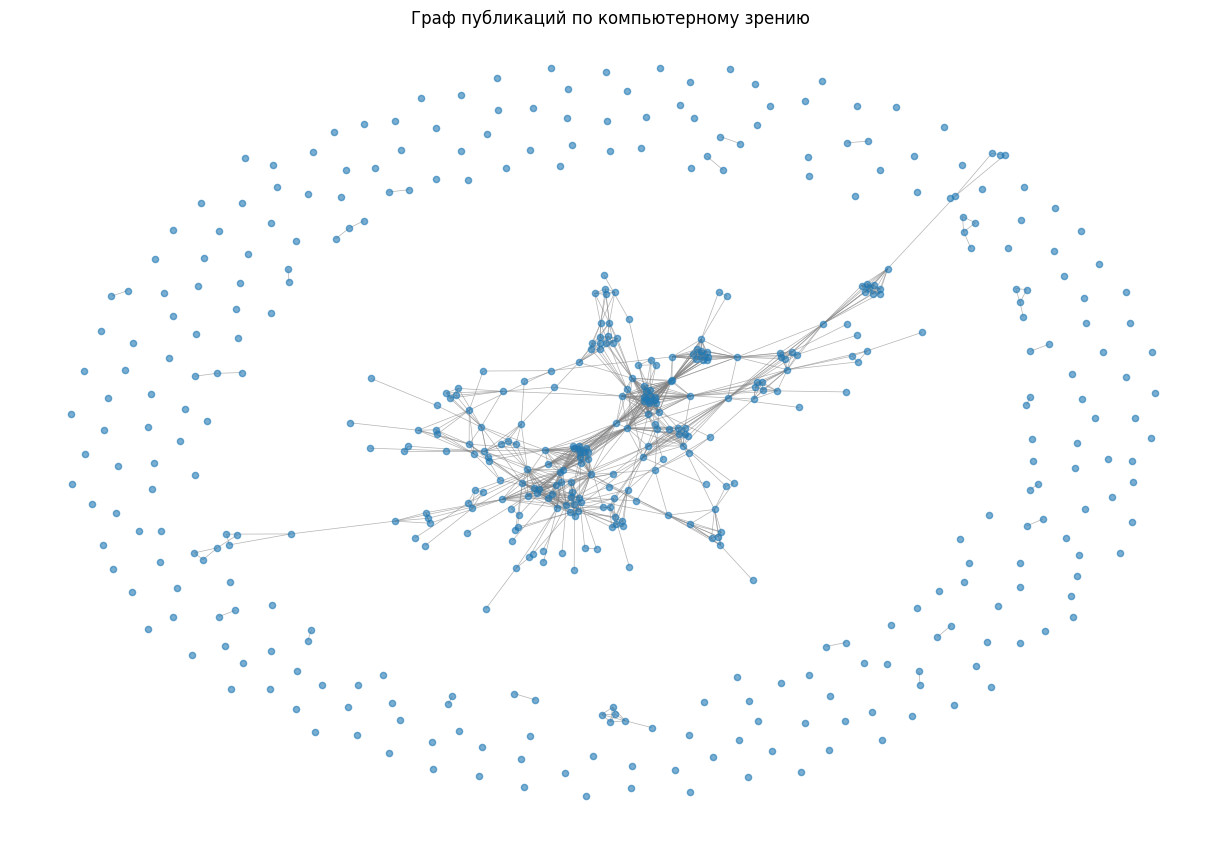

In [30]:
# Предполагаем, что у нас есть df с колонками 'title' и 'keywords'
# keywords - это строка с ключевыми словами, разделенными запятыми

G_papers = nx.Graph()

# Добавляем узлы (статьи)
for i, row in df.iterrows():
    G_papers.add_node(row['title'], abstract=row['abstract'], authors=row['authors'])

# Добавляем взвешенные ребра
for i, row1 in df.iterrows():
    # Извлекаем ключевые слова для первой статьи и приводим к множеству
    keywords1 = set(kw.strip() for kw in row1['keywords'].split(','))
    for j, row2 in df.iterrows():
        if i < j: # Чтобы не проверять пары дважды (A-B и B-A)
            keywords2 = set(kw.strip() for kw in row2['keywords'].split(','))
            # Находим пересечение ключевых слов
            common_keywords = keywords1.intersection(keywords2)
            weight = len(common_keywords)
            # Если есть общие ключевые слова, добавляем ребро
            if weight > 0:
                G_papers.add_edge(row1['title'], row2['title'], weight=weight)

# Дополнительная визуализация
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_papers, k=0.5, iterations=50)
nx.draw(G_papers, pos, node_size=20, alpha=0.6, edge_color='gray', width=0.5)
plt.title("Граф публикаций по компьютерному зрению")
plt.show()

In [34]:
def find_similar_papers(paper_title, graph, top_n=5):
    if paper_title not in graph:
        return "Статья не найдена в графе."

    # Собираем всех соседей и вес связи с ними
    neighbors = []
    for neighbor in graph.neighbors(paper_title):
        weight = graph[paper_title][neighbor]['weight']
        neighbors.append((neighbor, weight))

    # Сортируем по убыванию веса связи
    neighbors_sorted = sorted(neighbors, key=lambda x: x[1], reverse=True)
    return neighbors_sorted[:top_n]

# Пример использования
input_paper = df.iloc[3]['title'] # Берем первую статью для примера
similar = find_similar_papers(input_paper, G_papers)
for paper, weight in similar:
    print(f"Статья: {paper} | Общих ключевых слов: {weight}")

Статья: Logical methods of object recognition on satellite images using spatial
  constraints | Общих ключевых слов: 1
Статья: Visual Vocabulary Learning and Its Application to 3D and Mobile Visual
  Search | Общих ключевых слов: 1
Статья: Synthesising Dynamic Textures using Convolutional Neural Networks | Общих ключевых слов: 1
Статья: The Effect of Top-Down Attention in Occluded Object Recognition | Общих ключевых слов: 1
Статья: The use of Octree in point cloud analysis with application to cultural
  heritage | Общих ключевых слов: 1


In [35]:
print(f"Количество статей (узлов): {G_papers.number_of_nodes()}")
print(f"Количество связей (ребер): {G_papers.number_of_edges()}")
print(f"Плотность графа: {nx.density(G_papers):.3f}")
print(f"Средняя степень связности: {sum(dict(G_papers.degree()).values()) / G_papers.number_of_nodes():.1f}")

Количество статей (узлов): 500
Количество связей (ребер): 1149
Плотность графа: 0.009
Средняя степень связности: 4.6


## Метрики графа и качества кластеризации

Реализованы:
- Coverage разбиения,
- Conductance для сообщества,
- Средняя conductance,
- Silhouette на спектральных эмбеддингах.

Эти метрики помогут оценить качество найденных сообществ.


In [41]:
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import silhouette_score
import numpy as np

# --- Метрики графа и кластеризации ---
def coverage_of_partition(G, communities):
    m = G.number_of_edges()
    if m == 0:
        return 0.0
    intra = 0
    for comm in communities:
        intra += G.subgraph(comm).number_of_edges()
    return intra / m

def conductance_of_community(G, community):
    comm = set(community)
    cut_edges = sum(
        G[u][v].get("weight", 1.0)
        for u in comm for v in G.neighbors(u)
        if v not in comm
    )
    vol_comm = sum(G.degree(u, weight="weight") for u in comm)
    vol_rest = sum(G.degree(u, weight="weight") for u in G if u not in comm)
    denom = min(vol_comm, vol_rest)
    return cut_edges / denom if denom > 0 else 0.0

def average_conductance(G, communities):
    return np.mean([conductance_of_community(G, c) for c in communities])

def silhouette_on_embeddings(G, communities, n_components=16):
    nodes = list(G.nodes())
    # матрица смежности в формате csr, затем приведение индексов к int32
    A = nx.to_scipy_sparse_array(G, nodelist=nodes, weight="weight", format='csr')
    A.indices = A.indices.astype(np.int32)
    A.indptr = A.indptr.astype(np.int32)
    embed = SpectralEmbedding(n_components=n_components, affinity='precomputed').fit_transform(A)
    label_map = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            label_map[n] = cid
    labels = np.array([label_map.get(n, -1) for n in nodes])
    mask = labels >= 0
    if len(set(labels[mask])) < 2:
        return float("nan")
    return silhouette_score(embed[mask], labels[mask])


# communities_all = полный список сообществ по всему графу ключевых слов
communities_all = nx.community.louvain_communities(G, resolution=0.9)

print("=== Метрики для графа ключевых слов ===")
print("Модульность:", nx.community.modularity(G, communities_all))
print("Coverage:", coverage_of_partition(G, communities_all))
print("Средняя conductance:", average_conductance(G, communities_all))
print("Silhouette (по спектральным эмбеддингам):", silhouette_on_embeddings(G, communities_all))
print()
print("=== Общие метрики графа ===")
print("Число узлов:", G.number_of_nodes())
print("Число рёбер:", G.number_of_edges())
print("Плотность графа:", nx.density(G))
print("Средний clustering coefficient:", nx.average_clustering(G))
if nx.is_connected(G):
    print("Средняя длина пути:", nx.average_shortest_path_length(G))
else:
    print("Средняя длина пути: граф несвязный")



=== Метрики для графа ключевых слов ===
Модульность: 0.9278269117118848
Coverage: 0.9563318777292577
Средняя conductance: 0.00407611341902984
Silhouette (по спектральным эмбеддингам): 0.6999433577599133

=== Общие метрики графа ===
Число узлов: 1531
Число рёбер: 2748
Плотность графа: 0.0023462814256989535
Средний clustering coefficient: 0.8925876055260235
Средняя длина пути: граф несвязный
